# Dossier de presentation développement Yoan Capron

In [1]:
import warnings
from IPython.display import HTML
warnings.filterwarnings('ignore')

## Bonjour moi c'est Yoan. Développeur Fullstack

In [2]:
# lien image avatar:
HTML('<a href="#"><img style="margin-left: auto; margin-right: auto;" width="300" height="150" src="https://i.ibb.co/Jsb2Qwj/My-Rond-Avatar.png" alt="My-Rond-Avatar" border="0" /></a>')

# Je vous présente ici mes divers travaux de développement

## 0- Je vous passe html et css ;)

## 1- CS50 Application Python-Flask avec gestion de base de données postgresql grâce à l'ORM SQLAlchemy  

In [ ]:
## Le code source:

import os, json, ast, requests

from flask import Flask, session, render_template, request, redirect, jsonify, flash, url_for
from flask_session import Session
from sqlalchemy import create_engine
from sqlalchemy.orm import scoped_session, sessionmaker
from flask_bcrypt import Bcrypt
from models import *

app = Flask(__name__)


# Check for environment variable
if not os.getenv("DATABASE_URL"):
    raise RuntimeError("DATABASE_URL is not set")

# Configure session to use filesystem
app.config["SESSION_PERMANENT"] = False
app.config["SESSION_TYPE"] = "filesystem"
# app.config["SQLALCHEMY_DATABASE_URI"] = os.getenv("DATABASE_URL")
app.config["SQLALCHEMY_TRACK_MODIFICATIONS"] = False
# app.secret_key = "cs50-project1"

#init database
db.init_app(app)

#init session
Session(app)

#init bcrypt for encrypted passwords
bcrypt = Bcrypt(app)


# Set up database
engine = create_engine(os.getenv("DATABASE_URL"))
db = scoped_session(sessionmaker(bind=engine))


@app.route("/", methods=["POST", "GET"])
def index():
    return render_template("index.html")

@app.route("/register", methods=["POST", "GET"])
def register():
    if request.method == "POST":
        #if the request isn't contain username, return error message.
        if not request.form.get("username"):
            return render_template("errors.html", message = "Please insert username")

        #if the request isn't contain email, return error message.
        elif not request.form.get("email"):
            return render_template("errors.html", message = "Please, insert email")

        #if the request isn't contain password, return error message.
        elif not request.form.get("password"):
            return render_template("errors.html", message = "Please, insert new password")

        #if the request isn't contain confirmation password, return error message.
        elif not request.form.get("confirmation"):
            return render_template("errors.html", message = "Please, insert repeat password")

        #if the request password isn't egal to confirmation password, return error message.
        elif not request.form.get("password") == request.form.get("confirmation"):
            return render_template("errors.html", message = "Yours passwords don't match")

        else:
            #variable that take data in request password and encrypt with bcrypt
            hashed_password = bcrypt.generate_password_hash(request.form.get("password")).decode("utf-8")

            #variable that take from post request username, email and encrypted password in a table fonction
            adduser = Users(username = request.form.get("username"), email = request.form.get("email"), password = hashed_password)

            #post request username
            username = request.form.get("username")

            #post request email
            email = request.form.get("email")

            #username query
            userslist = db.execute("SELECT username FROM users WHERE username=(:username)",
                        {"username":username}).fetchone()

            #email query
            emailslist = db.execute("SELECT email FROM users WHERE email=(:email)",
                        {"email":email}).fetchone()

            #check if username already exist
            if userslist != None:
                return render_template("errors.html", message = "User already exist")

            #check if email already exist
            elif emailslist != None:
                return render_template("errors.html", message = "Email already exist")
            else:
                #add user in table
                db.add(adduser)
                db.commit()
                return redirect(url_for('success'))

    else:
        return render_template("register.html")


@app.route("/success")
def success():
    return render_template("success.html")

@app.route("/errors")
def errors():
    return render_template("errors.html")

@app.route("/login", methods=["POST", "GET"])
def login():

    if request.method == "POST":
        #username request
        username = request.form.get("loginUsername")

        #password request
        password = request.form.get("loginPassword")

        #username query that return row
        check = db.execute("SELECT * FROM users WHERE username = :username",
                    {"username":username}).fetchone()

        print(check)

        #user id of the username query in session
        session["user_id"] = check[0]

        #username of the username query in session
        session["user"] = check[1]

        #if not request username return error
        if not username:
            return render_template("errors.html", message = "Please insert username")

        #if not request password return error
        elif not password:
            return render_template("errors.html", message = "Please insert password")

        #check username
        elif check[1] == None:
            return render_template("errors.html", message = "User don't exist. Please register")

        #check password
        elif not bcrypt.check_password_hash(check[3], password):
            return render_template("errors.html", message = "Wrong password")

        #if logged, redirect to search
        elif "user" in session:
            return redirect(url_for("search", user = username))

    else:
        return render_template("login.html")


@app.route("/logout", methods=["POST", "GET"])
def logout():

    # erase session
    session.clear()

    return render_template("index.html")

# search page
@app.route("/<user>/search", methods=["POST", "GET"])
def search(user):

    #variable that contain username
    username = session["user"]

    if request.method == "POST":

        # search request
        if request.form.get("search"):

            # variable search request
            getsearch = request.form.get("search")

            # add wildcard to match multi words
            getsearch = '%' + getsearch + '%'

            # add a capital letter at the beginning of query
            getsearch = getsearch.title()

            # query to search book infos in books table
            query = db.execute("SELECT isbn, title, author, year FROM books WHERE (isbn LIKE :getsearch) OR (title LIKE :getsearch) OR (author LIKE :getsearch) OR (year LIKE :getsearch)",
            {"getsearch": getsearch}).fetchall()

            # if query don't get result
            if len(query) == 0:
                return render_template("errors.html", message = "No result")

            else:
                # erase session.query in session if it exist
                session.pop("query", None)

                # create session.query
                session["query"] = query

                return redirect(url_for("result", user = username))

        else:
            return render_template("{{user}}/search.html", user = username)

    else:
        return render_template("{{user}}/search.html", user = username)

# results page
@app.route("/<user>/result", methods=["POST", "GET"])
def result(user):
    result = session["query"]

    # variable username from session
    username = session["user"]

    return render_template("{{user}}/result.html", user = username, result = result, length = len(result))

# book page
@app.route("/<user>/<book>", methods=["POST", "GET"])
def book(user, book):

    if request.method == 'POST':

        # request to book table
        query = db.execute("SELECT isbn, title, author, year FROM books WHERE (title LIKE :book)",
        {"book": book}).fetchone()

        # put session.user into a variable
        rev_username = session["user"]

        # put query.isbn into a variable
        rev_isbn = query[0]

        # use rewiews class with some values and put into a variable
        addreview = Reviews(rev_isbn = rev_isbn, rev_username = rev_username, review = request.form.get("review"), rate = request.form.get("rate"))

        # request isbn from review for the username and put into a variable
        check = db.execute("SELECT rev_isbn FROM reviews WHERE rev_username=(:rev_username)",
                    {"rev_username":rev_username}).fetchone()

        if not request.form.get("review"):
            return render_template('/errors.html', message = "Please, insert a review.")

        if not request.form.get("rate"):
            return render_template('/errors.html', message = "Please, rate the book.")

        elif check != None:
            return render_template('/errors.html', message = "You already had posted a review for this book")

        else:
            # add a review into review table
            db.add(addreview)
            db.commit()
            return render_template('/success.html', message = "You review is submitted!")

    if request.method == 'GET':

        # request to book table
        query = db.execute("SELECT isbn, title, author, year FROM books WHERE (title LIKE :book)",
        {"book": book}).fetchone()

        # goodreads api request into a variable
        res = requests.get("https://www.goodreads.com/book/review_counts.json", params={"key": "rPpQMNygX27uKlbVg3SzQ", "isbns": query[0]}).json()

        # res.books
        res = res["books"]

        res = res[0]

        rev_username = session["user"]

        rev_isbn = query[0]

        # request from review with isbn
        all_reviews = db.execute("SELECT rev_username, review, rate FROM reviews WHERE rev_isbn=(:rev_isbn)",
                    {"rev_isbn":rev_isbn}).fetchall()

        lenght = len(all_reviews)
        return render_template("{{user}}/{{book}}.html", user = user, book = book, query = query, res = res, lenght = lenght, all_reviews = all_reviews)

# api response to GET requests
@app.route("/api/<isbn>", methods=["POST", "GET"])
def get_api(isbn):
    if request.method == 'GET':

        # isbn integer to string
        str_isbn = str(isbn)

        # request from books infos needed into a variable
        query = db.execute("SELECT isbn, title, author, year FROM books WHERE isbn=(:str_isbn)",
        {"str_isbn" :str_isbn}).fetchone()

        # turn query into a dictionnary
        d = dict(query.items())

        # list of all values
        a = list(d.values())

        if not len(a) == 0:
            query_isbn = a[0]
            query_title = a[1]
            query_author = a[2]
            query_year = a[3]
            query_year = int(query_year)
            all_reviews = db.execute("SELECT review, rate FROM reviews WHERE rev_isbn=(:query_isbn)",
                        {"query_isbn":query_isbn}).fetchall()

            # turn all_reviews into a dictionnary
            k = dict(all_reviews)

            # turn all k values into a list
            l = list(k.values())

            # turn all string to integer in a list
            l = list(map(int, l))

            # sum of a list
            m = sum(l)

            if not m == 0:
                rate_sum = float(m)
                review_float = len(l)
                review_float = float(review_float)
                average_score = rate_sum / review_float
                review_count = int(review_float)

                json_query = {
                    "title": query_title,
                    "author": query_author,
                    "year": query_year,
                    "isbn": str_isbn,
                    "review_count": review_count,
                    "average_score": average_score
                }

                return jsonify(json_query)

            else:
                return render_template('errors.html', message = "404 error"), 404

        else:
            return render_template('errors.html', message = "404 error"), 404

    else:
        return render_template('errors.html', message = "404 error"), 404

### Sur ce projet j'ai aussi créé des classes en Orienté Objet pour automatisé la création de la base de données

In [ ]:
from flask_sqlalchemy import SQLAlchemy

db = SQLAlchemy()

class Users(db.Model):
    __tablename__ = "users"
    id = db.Column(db.Integer, primary_key=True)
    username = db.Column(db.String, nullable=False)
    email = db.Column(db.String, nullable=False)
    password = db.Column(db.String, nullable=False)

    def __init__(self, username, email, password):
        self.username = username
        self.email = email
        self.password = password


class Books(db.Model):
    __tablename__ = "books"
    id = db.Column(db.Integer, primary_key=True)
    isbn = db.Column(db.String, nullable=False)
    title = db.Column(db.String, nullable=False)
    author = db.Column(db.String, nullable=False)
    year = db.Column(db.String, nullable=False)

    def __init__(self, isbn, title, author, year):
        self.isbn = isbn
        self.title = title
        self.author = author
        self.year = year

class Reviews(db.Model):
    __tablename__ = "reviews"
    id = db.Column(db.Integer, primary_key=True)
    rev_isbn = db.Column(db.String, nullable=False)
    rev_username = db.Column(db.String, nullable=False)
    review = db.Column(db.String, nullable=False)
    rate = db.Column(db.String, nullable=False)

    def __init__(self, rev_isbn, rev_username, review, rate):
        self.rev_isbn = rev_isbn
        self.rev_username = rev_username
        self.review = review
        self.rate = rate

In [3]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=cx1t0Oz45-g&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation CS50 Flask</h1></a>")

## 2- Python-Flask/Javascript single page application

In [ ]:
let username = localStorage.getItem("username");




document.addEventListener("DOMContentLoaded", () => {





  if (username === null) {
    const request = new XMLHttpRequest();
    request.open('GET', '/unregistered');
    request.onload = () => {
      const response = request.responseText;
      document.querySelector("#body").innerHTML = response;
      if (document.getElementById("index_form_container")){
        document.querySelector("#submit").disabled = true;
        document.querySelector("#name").onkeyup = () => {
          if (document.querySelector("#name").value.length > 0) {
              document.querySelector("#submit").disabled = false;
          } else {
              document.querySelector("#submit").disabled = true;
          }; // if (document.querySelector("#name").value.length > 0)
        }; // document.querySelector("#name").onkeyup
        document.querySelector("#myForm").onsubmit = () => {
          const name = document.querySelector("#name").value;
          localStorage.setItem("username", name);
          window.location.href = window.location.pathname;
          location.reload();
        }; // document.querySelector("#myForm").onsubmit
      }; // if (document.getElementById("index_form_container"))
    }; // onload
    request.send();

  } else {

    const request = new XMLHttpRequest();
    request.open('GET', '/registered');
    request.onload = () => {
      const response = request.responseText;
      document.querySelector("#body").innerHTML = response;
      document.querySelector("#hello").innerHTML = `Hello ${username}`;
      const request2 = new XMLHttpRequest();
      request2.open('GET', '/channel');
      request2.onload = () => {
        const response2 = request2.responseText;
        alert(response2);
        const myJson2 = JSON.parse(response2);
      };
      request2.send();


      document.querySelector("#button").onclick = () => {
        localStorage.removeItem('username');
        window.location.href = window.location.pathname;
        location.reload();
        return false;
      }; // document.querySelector("#button").onclick

      document.querySelector("#myForm2").onsubmit = () => {
        const creator = localStorage.getItem("username");
        const channelName = document.querySelector("#channelName").value;
        const data = new FormData();
        data.append("creator", creator);
        data.append("channelName", channelName);
        const request = new XMLHttpRequest();
        request.open('POST', '/create');
        request.onload = () => {
          const response = request.responseText;
          const myJson = JSON.parse(response);
          const su = myJson["success"];
          if (su === true){
            const dat = myJson["data"];
            const channelName = dat["channel_name"];
            const creator = dat["creator"];
            const creationDate = dat["creation_date"];
            const myForm = document.createElement("form");
            myForm.id = "myForm"
            myForm.method = "post"
            const inp = document.createElement("input");
            inp.id = "inp";
            inp.placeholder = "tape your text here";
            const but = document.createElement("button");
            but.type = "submit";
            but.id = "but";
            document.querySelector("#body").innerHTML = `<br><div id="channel_view">Hello ${creator}, your channel is ${channelName} and was created on ${creationDate}</div>`;
            document.querySelector("#body").appendChild(myForm);
            document.querySelector("#myForm").appendChild(inp);
            document.querySelector("#myForm").appendChild(but);
            document.querySelector("#but").innerHTML = "submit";
            const ul = document.createElement("ul");
            ul.id = "ulist";
            document.querySelector("#body").appendChild(ul);
            document.querySelector("#myForm").onsubmit = () => {
              const data = document.querySelector("#inp").value;
              let li = [];
              let dataLi = "";
              li.push(data);
              dataLi += "<li>" + li + "</li>";
              document.querySelector("#ulist").innerHTML += dataLi;
              document.querySelector("#inp").value = "";
              return false;
            }; // on submit
          };
        }; // onload
        request.send(data);
      }; // on submit
      window.onpopstate = function(event) {
      };
      history.pushState(null,'','');
    }; // onload
    request.send();
  }; // if (username === null)
  var length=history.length;
  for (i = 0; i < lenght; i++) {
    history.pushState({},'','');
  };
});

## 3-Machine learning Python: Scikit-Learn - Pandas - Numpy - Matplotlib - Seaborn

In [4]:
# lien article:
HTML("<a href='https://www.linkedin.com/posts/yoan-capron-18857b59_machinelearning-supervisedlearning-shares-activity-6692357795519438848-nDjt'><h1 style='text-align: center;'>Lien vers le post LinkedIn</h1></a>")    

### Prédiction du prix des actions Facebook 2017 entrainé sur 2016

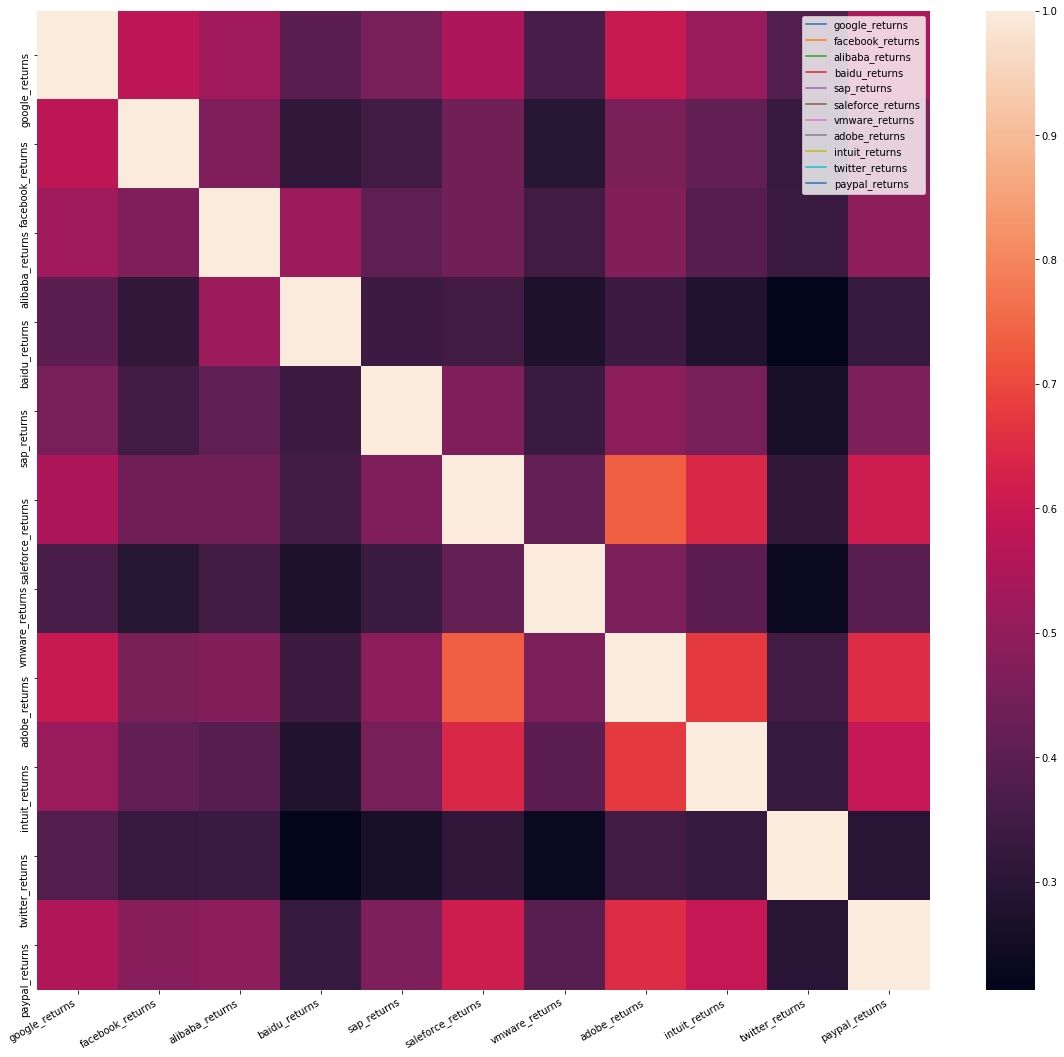

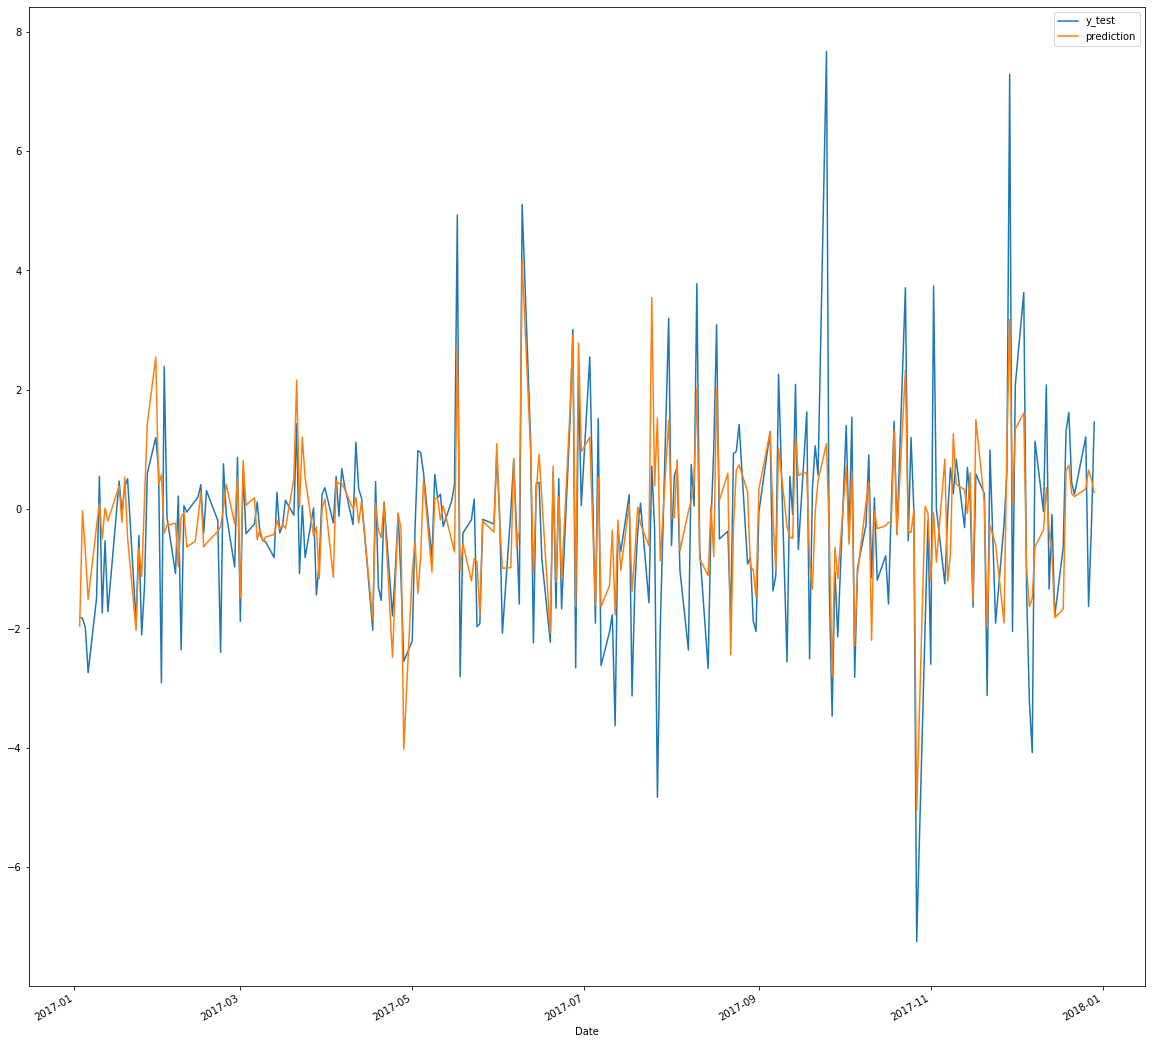

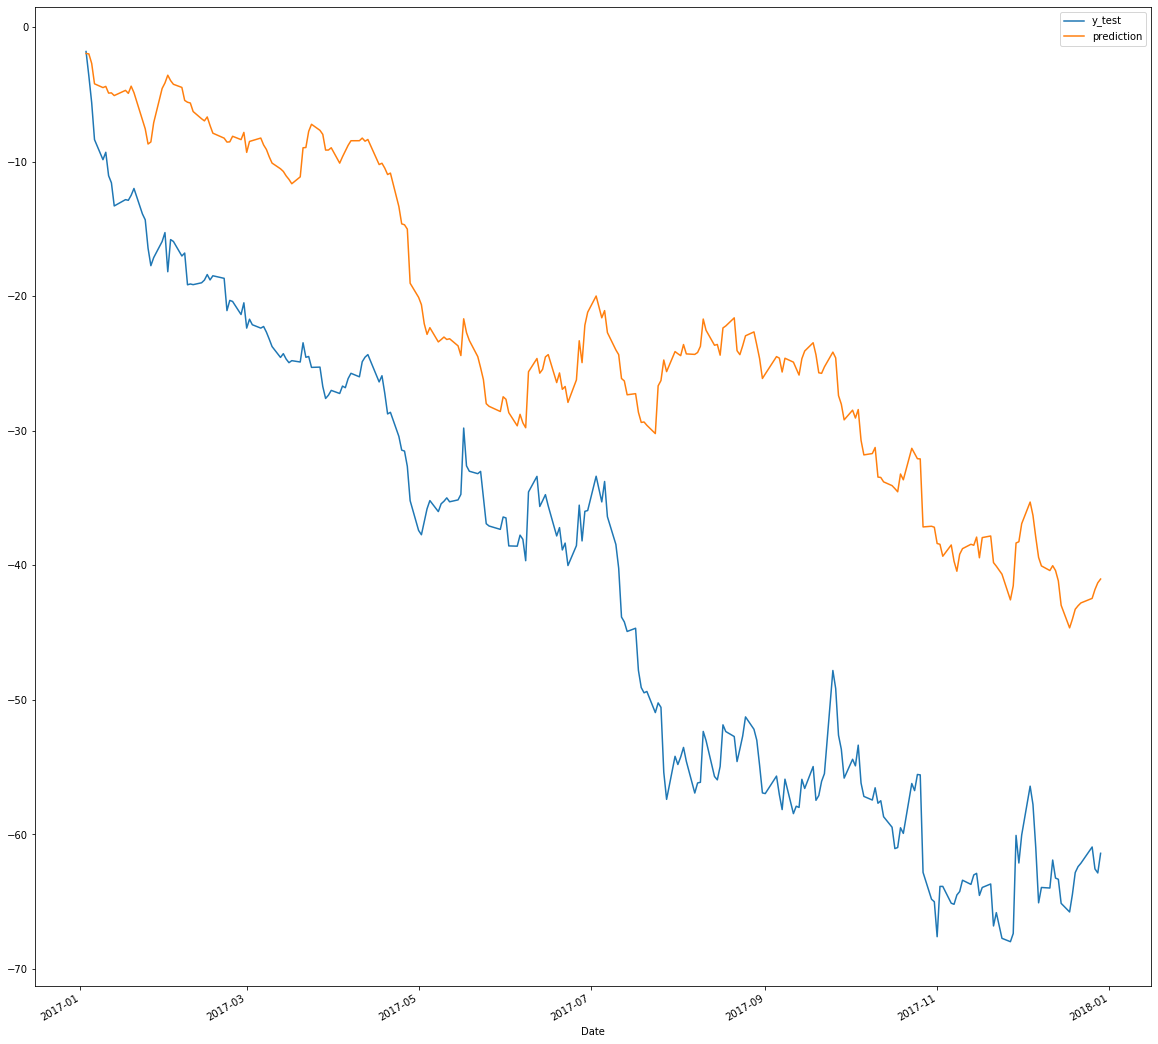

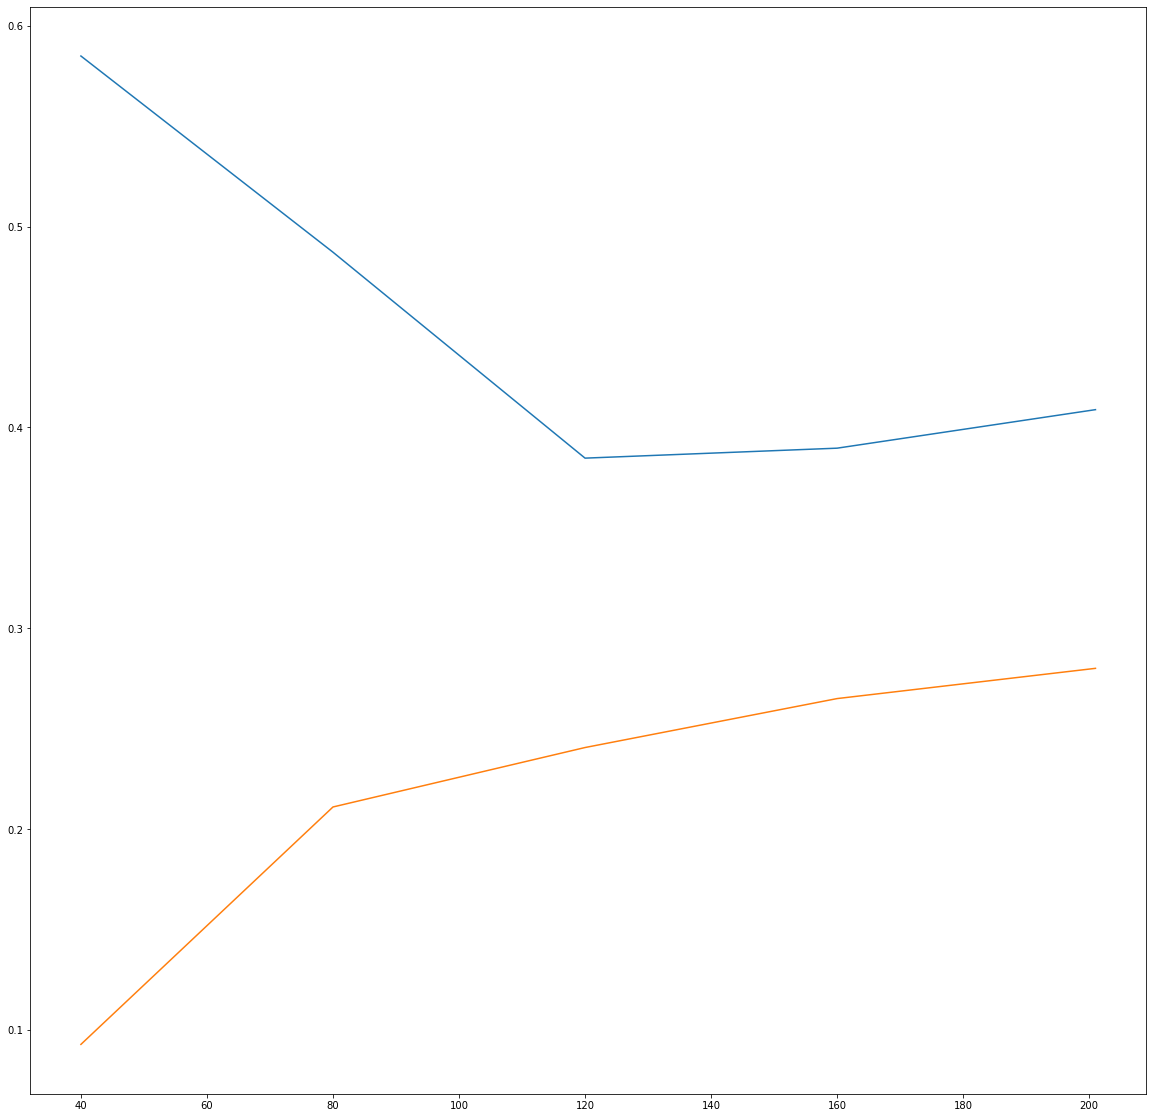

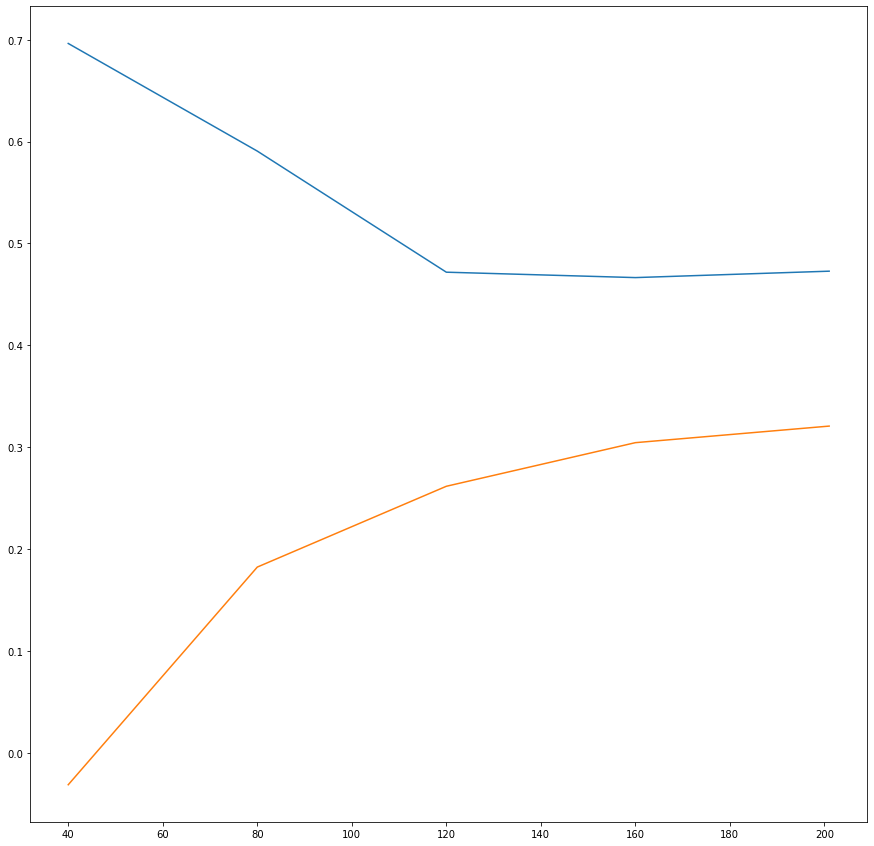

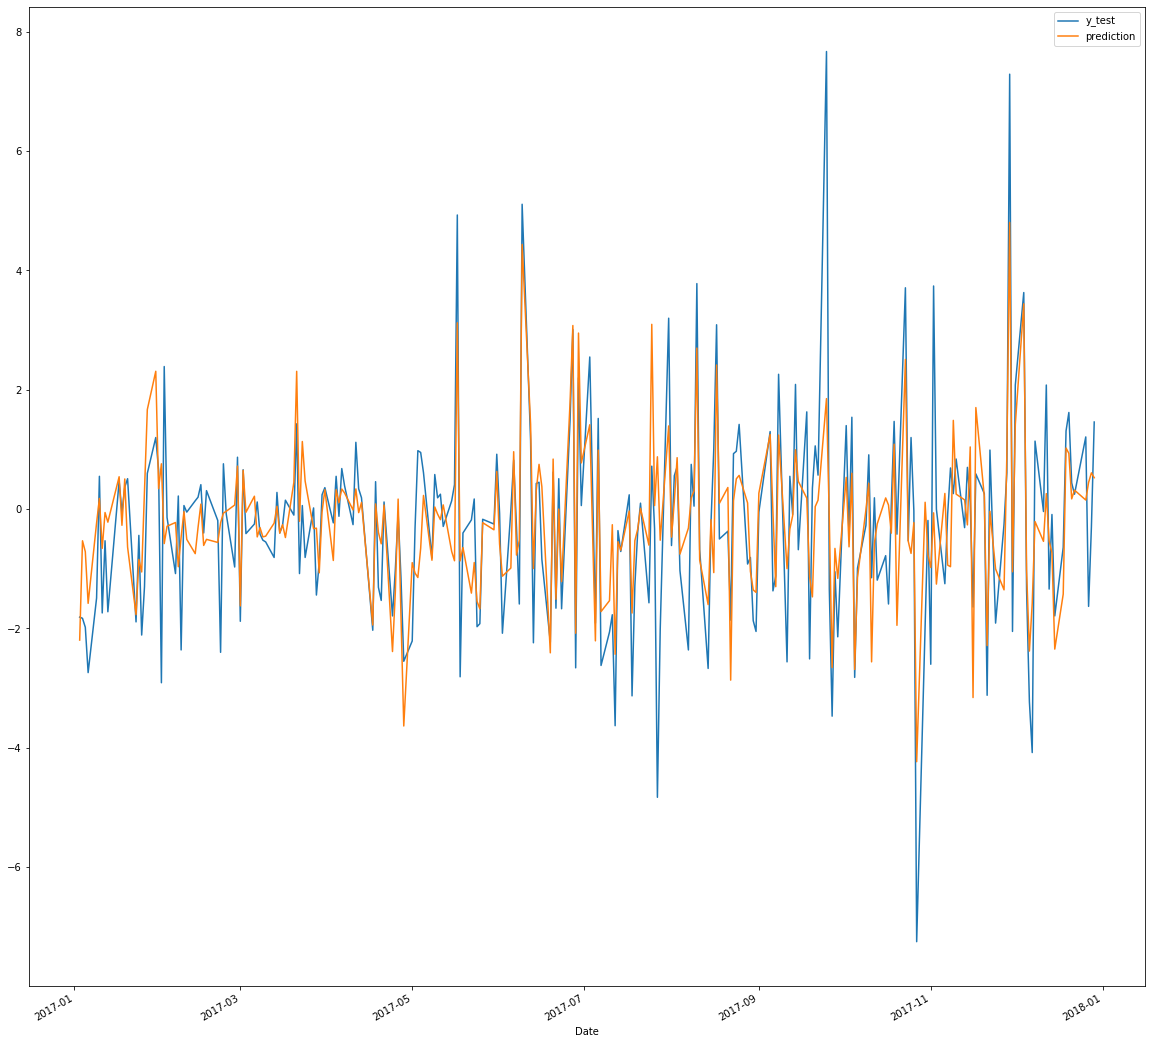

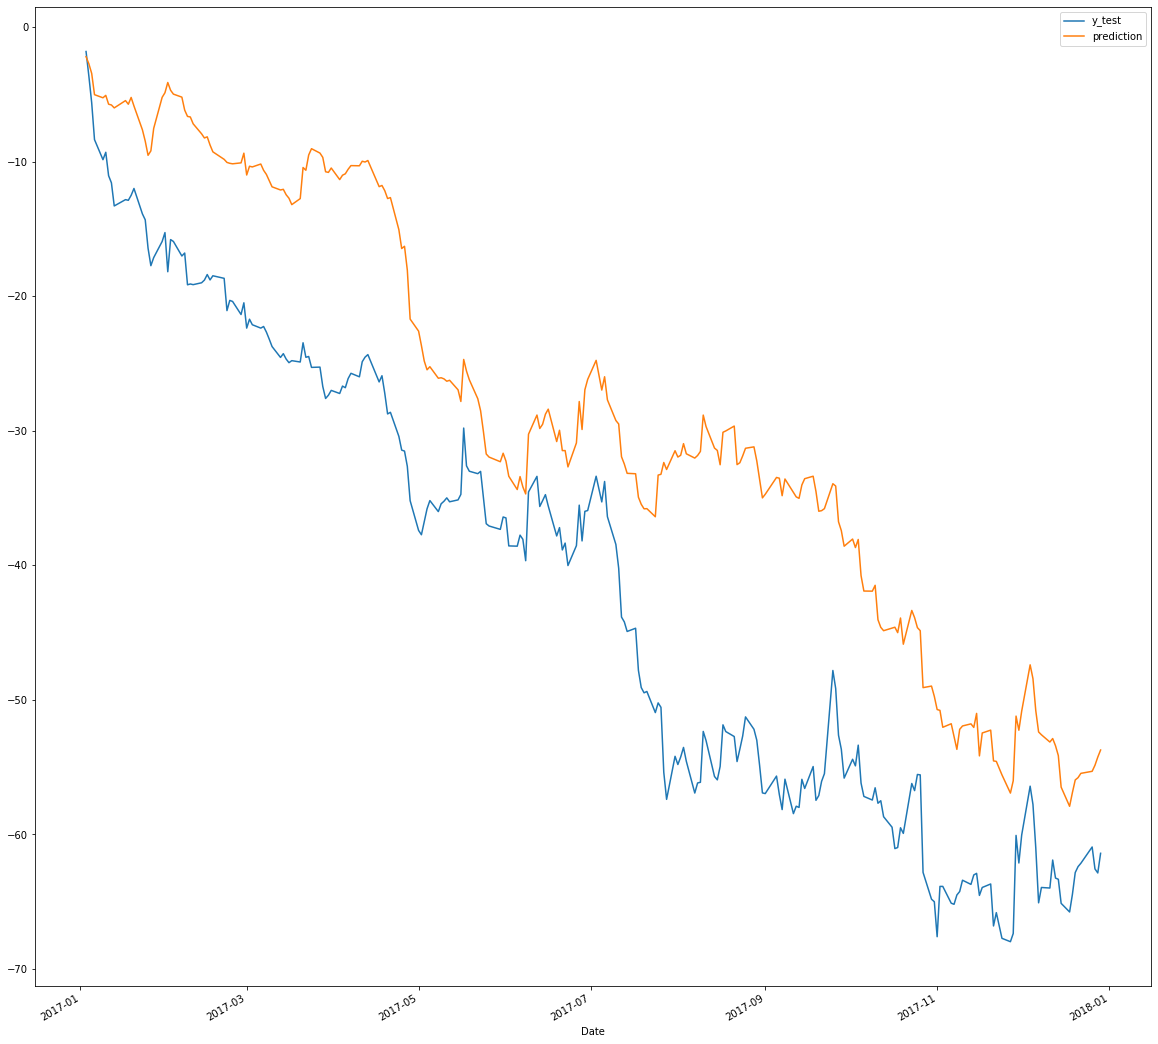

In [5]:
### Advanced ML prediction trades on internet compagny shares
#####- data importation
#####- data processing
#####- simple regressor model
#####- advanced optimization

import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Data importation

start_date = '2012-08-18'
end_date = '2019-12-31'

google_data = data.get_data_yahoo('GOOGL', start_date, end_date)
facebook_data = data.get_data_yahoo('FB', start_date, end_date)
alibaba_data = data.get_data_yahoo('BABA', start_date, end_date)
baidu_data = data.get_data_yahoo('BIDU', start_date, end_date)
sap_data = data.get_data_yahoo('SAP', start_date, end_date)
saleforce_data = data.get_data_yahoo('CRM', start_date, end_date)
vmware_data = data.get_data_yahoo('VMW', start_date, end_date)
adobe_data = data.get_data_yahoo('ADBE', start_date, end_date)
intuit_data = data.get_data_yahoo('INTU', start_date, end_date)
twitter_data = data.get_data_yahoo('TWTR', start_date, end_date)
paypal_data = data.get_data_yahoo('PYPL', start_date, end_date)



### Simple data processing 

data_df = pd.DataFrame({"google_returns": google_data["Close"].shift(1) - google_data["Close"], "facebook_returns": facebook_data["Close"].shift(1) - facebook_data["Close"], "alibaba_returns": alibaba_data["Close"].shift(1) - alibaba_data["Close"], "baidu_returns": baidu_data["Close"].shift(1) - baidu_data["Close"], "sap_returns": sap_data["Close"].shift(1) - sap_data["Close"], "saleforce_returns": saleforce_data["Close"].shift(1) - saleforce_data["Close"], "vmware_returns": vmware_data["Close"].shift(1) - vmware_data["Close"], "adobe_returns": adobe_data["Close"].shift(1) - adobe_data["Close"], "intuit_returns": intuit_data["Close"].shift(1) - intuit_data["Close"], "twitter_returns": twitter_data["Close"].shift(1) - twitter_data["Close"], "paypal_returns": paypal_data["Close"].shift(1) - paypal_data["Close"]})
data_df.dropna(axis=0, inplace=True)
data_df.head()

# plotting datas with matplotlib
data_df.cumsum().plot(figsize=(20, 20))

# correlation visualisation with seaborn heatmap
import seaborn as sns
sns.heatmap(data_df.corr())

# set features as X and target as y with default features for this time
X = data_df.drop(["facebook_returns"], axis=1)
y = data_df["facebook_returns"]


# for split the datetime dataset, I use 2016 datas as train set and 2017 data as test set
X_train, X_test, y_train, y_test = X["2016"], X["2017"], y["2016"], y["2017"]

### Simple regressor model

# simple ElasticNet model with default values
from sklearn.linear_model import ElasticNet

model = ElasticNet()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

# create a Pandas DataFrame with target test set as y_test and model prediction of test features set
comparison = pd.DataFrame({"y_test": y_test, "prediction": model.predict(X_test)})

comparison.plot(figsize=(20, 20))

# Cumulate model prediction result in front of keep Facebook shares
comparison.cumsum().plot(figsize=(20, 20))

# Verify if the model is overfitted or underfitted with learning curve
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.2, 1.0, 5), cv=5)

plt.figure(figsize=(20, 20))
plt.plot(N, train_score.mean(axis=1))
plt.plot(N, val_score.mean(axis=1))


### Advanced model optimization

# I use GridSearchCV to cross validates differents parameters
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha": np.arange(0.1, 0.9, 0.1),
              "l1_ratio": np.arange(0.1, 1., 0.1),
              "tol": np.arange(0.00005, 0.0005, 0.00005)
              }

grid = GridSearchCV(ElasticNet(), param_grid, cv=5)

grid.fit(X_train, y_train)

# Best parameters got by GridSearchCV
grid.best_params_

grid_best_params = ElasticNet(alpha=0.2, l1_ratio=0.6, tol=5e-05)

grid_best_params.fit(X_train, y_train)

#grid score
grid_best_params.score(X_train, y_train), grid.score(X_test, y_test)

# Again I use learning curve to verify overfit or underfit

N, train_score, val_score = learning_curve(grid_best_params, X_train, y_train, train_sizes=np.linspace(0.2, 1.0, 5), cv=5)

plt.figure(figsize=(15, 15))
plt.plot(N, train_score.mean(axis=1))
plt.plot(N, val_score.mean(axis=1))

# create a Pandas DataFrame with target test set as y_test and model prediction of test features set
grid_comparison = pd.DataFrame({"y_test": y_test, "prediction": grid.predict(X_test)})

# to plot advanced model prediction result in front of keep Facebook shares
grid_comparison.plot(figsize=(20, 20))

# Cumulate advanced model prediction result in front of keep Facebook shares
grid_comparison.cumsum().plot(figsize=(20, 20))

### Analyse de campagnes de pubs Facebook et google Python: Scikit-Learn - Pandas - Numpy - Matplotlib

In [6]:
# lien article:
HTML("<a href='https://www.linkedin.com/pulse/r%C3%A9soudre-un-vrai-probl%C3%A8me-gr%C3%A2ce-au-machine-learning-yoan-capron/'><h1 style='text-align: center;'>Lien vers l'article LinkedIn</h1></a>")        

(0.9388739549672084, 0.9770140300962202)

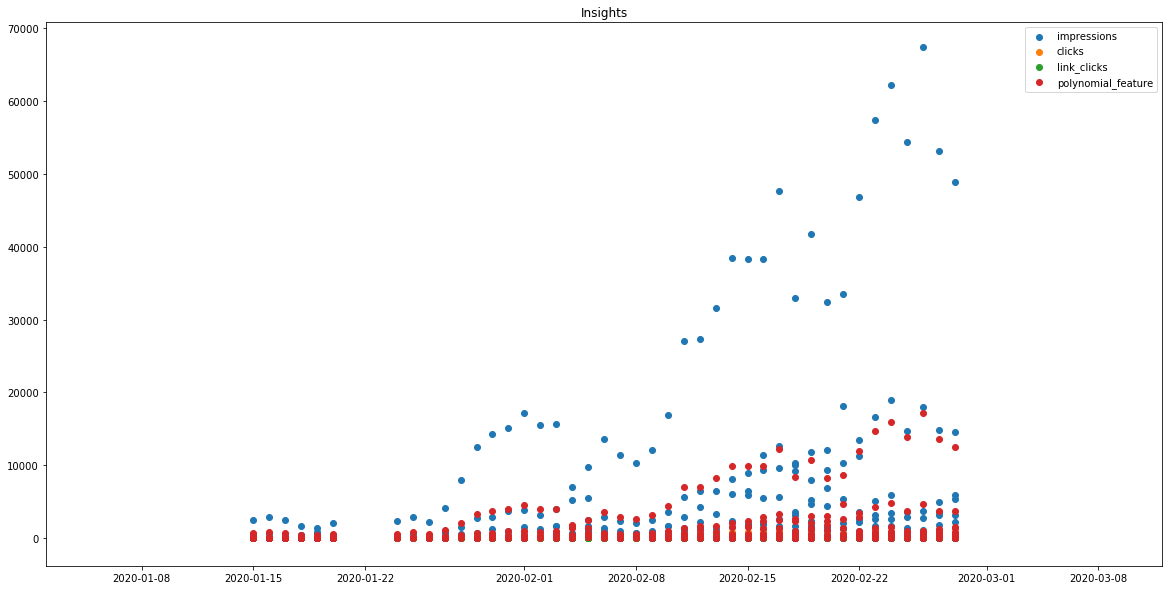

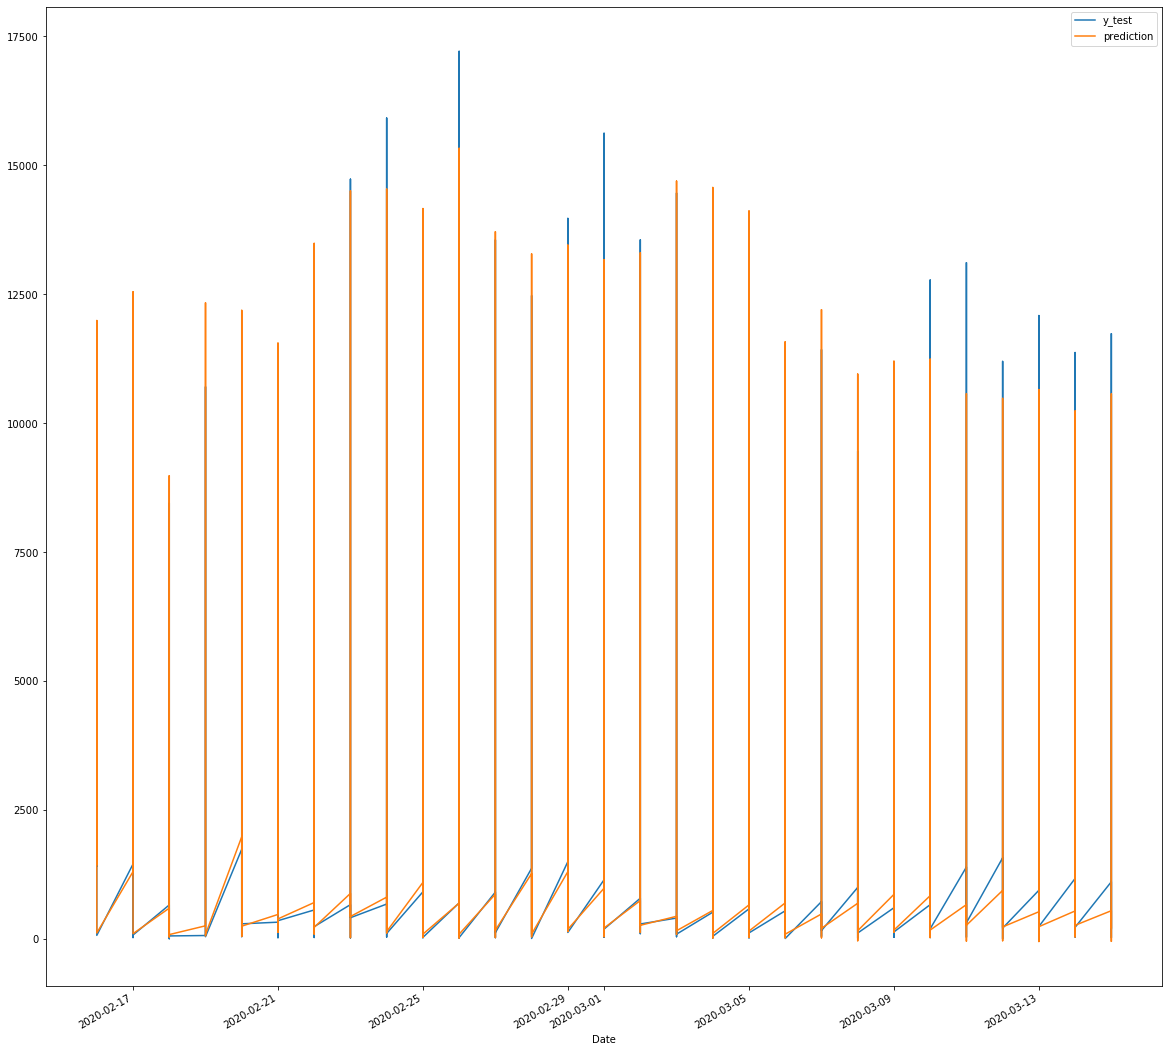

In [7]:
### Machine learning model prediction of campagns insights with Python and Scikit Learn 

# import necessary python modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# read the excel dataset provided, parsing to Datetime format and formatting of unset values 

data = pd.read_excel('Data Analyst Assignment.xlsx', index_col=0, header=0, parse_dates=True, na_values="'-")
data.head()

# drop each rows which contains values not provided

data.dropna(axis=0, inplace=True)

# create a DataFrame which contains insights colums (impressions, clicks, link_clicks) only

insights = data.drop(['product', 'phase', 'campaign_platform', 'campaign_type',
       'communication_medium', 'subchannel', 'audience_type', 'creative_type',
       'creative_name', 'device', 'age', 'spends'], axis=1)
insights.shape

# feature engineering from all insights colums to one colums with scikitlearn polynomialFeature

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(1)
data["polynomial_feature"] = poly.fit_transform(insights).mean(axis=1)

# Plotting scatter between each insight and the new create feature to verify   

plt.figure(figsize=(20, 10))
plt.scatter(data["2020-01-15":"2020-02-28"].index, data["2020-01-15":"2020-02-28"]["impressions"], label = "impressions")
plt.scatter(data["2020-01-15":"2020-02-28"].index, data["2020-01-15":"2020-02-28"]["clicks"], label = "clicks")
plt.scatter(data["2020-01-15":"2020-02-28"].index, data["2020-01-15":"2020-02-28"]["link_clicks"], label = "link_clicks")
plt.scatter(data["2020-01-15":"2020-02-28"].index, data["2020-01-15":"2020-02-28"]["polynomial_feature"], label = "polynomial_feature")
plt.legend()
plt.title("Insights")

# Separate target and features in 2 datasets 

X = data.drop(["product", "phase", 'impressions', 'clicks',
       'link_clicks', 'polynomial_feature'], axis=1)
y = data['polynomial_feature']

# Split train set (2 months) and test set (the last month)

X_train, X_test, y_train, y_test = X["2019-12-16":"2020-02-15"], X["2020-02-16":"2020-03-20"], y["2019-12-16":"2020-02-15"], y["2020-02-16":"2020-03-20"]

# Model creation with advanced pipeline combination

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import SGDRegressor

# creation of 2 feature types which will be formated in differents way
numerical_features = ['spends']
categorie_variables = ['campaign_platform', 'campaign_type', 'communication_medium',
       'subchannel', 'audience_type', 'creative_type', 'creative_name',
       'device', 'age']

# creation of 2 pipelines types which uses 2 differentes transformers according to the datatype
numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
categorie_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# preprocessing of datatypes
preprocessor = make_column_transformer((numerical_pipeline,  numerical_features), (categorie_pipeline, categorie_variables))

# last pipeline with SGDRegressor estimator implementing
model = make_pipeline(preprocessor, SGDRegressor(random_state=0))
model.fit(X_train, y_train)


# Score results
model.score(X_train, y_train), model.score(X_test, y_test)

# create a Pandas DataFrame with target test set as y_test and model prediction of the test features set
comparison = pd.DataFrame({"y_test": y_test, "prediction": model.predict(X_test)})

# Plot the comparison between predictions and real values of the test set
comparison["2020-01-15":"2020-03-15"].plot(figsize=(20, 20))

# I use SelectKBest and to select features and remove if necessary with f_classif anova statistical test
from sklearn.feature_selection import SelectKBest, f_classif


selector = make_pipeline(SelectKBest(f_classif, k=11), SGDRegressor(random_state=0))

model = make_pipeline(preprocessor, selector)
model.fit(X_train, y_train)


# Score results with GridSearch
model.score(X_train, y_train), model.score(X_test, y_test)

### results with SelectKBest are close to standard results

## 4- développement mobile Flutter: Dart

### Une application de jeu de dés mobile Android IOS

In [ ]:
### le code source:

import 'dart:math';
import 'package:flutter/material.dart';

void main() {
  return runApp(
    MaterialApp(
      home: Scaffold(
        backgroundColor: Colors.red,
        appBar: AppBar(
          title: Text('Dicee'),
          backgroundColor: Colors.red,
          centerTitle: true,
        ),
        body: DicePage(),
      ),
    ),
  );
}

class DicePage extends StatefulWidget {


  @override
  _DicePageState createState() => _DicePageState();
}

class _DicePageState extends State<DicePage> {
  int leftDiceNumber = 1;
  int rightDiceNumber = 1;
  void changeDiceFace() {
    setState(() {
      leftDiceNumber = Random().nextInt(6) + 1;
      rightDiceNumber = Random().nextInt(6) + 1;
    });
  }

  @override
  Widget build(BuildContext context) {
    return Center(
      child: Row(
        children: <Widget>[
          Expanded(
            child: FlatButton(
                onPressed: () {
                  changeDiceFace();
                },
                child: Image.asset("images/dice$leftDiceNumber.png")),
          ),
          Expanded(
            child: FlatButton(
                onPressed: () {
                  changeDiceFace();
                },
                child: Image.asset("images/dice$rightDiceNumber.png")),
          ),
        ],
      ),
    );
  }
}


### Une application de jeu musicale Android et IOS

In [ ]:
### le code source

import 'package:flutter/cupertino.dart';
import 'package:flutter/material.dart';
import 'package:audioplayers/audio_cache.dart';

void main() => runApp(XylophoneApp());

class XylophoneApp extends StatelessWidget {

  void playSound(int soundNumber) {
    final player = AudioCache();
    player.play('note$soundNumber.wav');
  }

  @override
  Widget build(BuildContext context) {
    return MaterialApp(
      home: Scaffold(
        backgroundColor: Colors.black,
        body: SafeArea(
          child: Center(
            child: Column(
              crossAxisAlignment: CrossAxisAlignment.stretch,
              children: <Widget>[
                Expanded(
                  child: FlatButton(
                    color: Colors.red,
                    padding: EdgeInsets.all(20.0),
                    onPressed: () {
                      playSound(1);
                    },
                  ),
                ),
                Expanded(
                  child: FlatButton(
                    color: Colors.orange,
                    padding: EdgeInsets.all(20.0),
                    onPressed: () {
                      playSound(2);
                    },
                  ),
                ),
                Expanded(
                  child: FlatButton(
                    color: Colors.yellow,
                    padding: EdgeInsets.all(20.0),
                    onPressed: () {
                      playSound(3);
                    },
                  ),
                ),
                Expanded(
                  child: FlatButton(
                    color: Colors.green,
                    padding: EdgeInsets.all(20.0),
                    onPressed: () {
                      playSound(4);
                    },
                  ),
                ),
                Expanded(
                  child: FlatButton(
                    color: Colors.teal,
                    padding: EdgeInsets.all(20.0),
                    onPressed: () {
                      playSound(5);
                    },
                  ),
                ),
                Expanded(
                  child: FlatButton(
                    color: Colors.blue,
                    padding: EdgeInsets.all(20.0),
                    onPressed: () {
                      playSound(6);
                    },
                  ),
                ),
                Expanded(
                  child: FlatButton(
                    color: Colors.purple,
                    padding: EdgeInsets.all(20.0),
                    onPressed: () {
                      playSound(7);
                    },
                  ),
                ),
              ],
            ),
          ),
         ),
       ),
    );
  }
}


In [8]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=D-PkDojC1z4&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation Flutter cross-platform mobile développement</h1></a>")

## 5- Navigation automatisé testing/scraping Python: Selenium - Beautifulsoup

In [9]:
# lien article:
HTML("<a href='https://www.linkedin.com/pulse/web-scraping-avec-python-et-selenium-driver-yoan-capron/'><h1 style='text-align: center;'>Lien l'article LinkedIn</h1></a>")

In [ ]:
### le code source:

import time, csv

from bs4 import BeautifulSoup as soup
from selenium import webdriver

options = webdriver.FirefoxOptions()

# options.add_argument('-headless')

def next_page():

    next_button = driver.find_element_by_xpath('//*[@id="n7lv7yjyC35__section-pagination-button-next"]')
    next_button.click()
    time.sleep(15)
    page_html = driver.page_source
    page_soup = soup(page_html, "html.parser")
    containers2 = page_soup.findAll("div",{"class":"section-result"})
    filename = "data.csv"
    f2 = open(filename, "a")
    time.sleep(2)
    for container in containers2 :
        name = container.find("span",{"jstcache":"117"}).text
        address = container.find("span",{"jstcache":"132"}).text
        number = container.find("span",{"jstcache":"145"}).text

        f2.write(name + "," + address + "," + number + "\n")


# past url
my_url = "https://www.google.com/maps/search/Pharmacies/@46.2178463,6.1264178,14z"



# set firefox
driver = webdriver.Firefox(firefox_options=options)

# opening connection
driver.get(my_url)

# wait for all content loaded
time.sleep(10)




#grabbing the page
page_html = driver.page_source

if driver.find_element_by_css_selector(".widget-consent-description").is_displayed():
    but = driver.find_element_by_css_selector(".widget-consent-button-later")
    but.click()
    time.sleep(5)

#html parsing
page_soup = soup(page_html, "html.parser")



#grab each products
containers = page_soup.findAll("div",{"class":"section-result"})



filename = "data.csv"

f = open(filename, "w")

headers = "pharmacie name, address, phone number\n"

f.write(headers)

for container in containers :
    name = container.find("span",{"jstcache":"117"}).text
    address = container.find("span",{"jstcache":"132"}).text
    number = container.find("span",{"jstcache":"145"}).text

    f.write(name + "," + address + "," + number + "\n")

for i in range(8):
    next_page()

f.close()

driver.close()

In [10]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=G3uFf8XmVIo&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation web scraping avec Selenium</h1></a>")

## 6- Splunk pdf Python/NodeJS: Puppeteer

In [ ]:
const puppeteer = require('puppeteer');
const fs = require('fs');
const util = require('util');
const chunks = [];
const path = require('path');

(async () => {
    // load login
    console.log("launching browser");
    const browser = await puppeteer.launch({headless: true, ignoreHTTPSErrors: true, args: ['--no-sandbox']});


    const page = await browser.newPage();

    async function chunkPDF(chunkid, id) {
        console.log("### chunk call (" + chunkid + "/" + chunks.length + ") ###");

        if (chunkid == chunks.length - 1) {
            await page.goto("https://localhost:8000/en-US/custom/smart_exporter_app/service/sendpdfexport/" + encodeURIComponent(chunks[chunkid]) + "/" + id.toString() + "/" + chunkid.toString() + "/" + chunks.length.toString() + "/" + ("##scheduleparams##").split(".json").join(""));

            await setTimeout(function () {
                console.log("end recursive call ...");
            }, 1000);

        } else {
            if (chunkid < chunks.length - 1) {
                await page.goto("https://localhost:8000/en-US/custom/smart_exporter_app/service/sendpdfexport/" + encodeURIComponent(chunks[chunkid]) + "/" + id.toString() + "/" + chunkid.toString() + "/" + chunks.length.toString() + "/" + ("##scheduleparams##").split(".json").join(""));
                chunkid = chunkid + 1;
                await chunkPDF(chunkid, id);
            }
        }
    }

    console.log("opening login screen");
    await page.goto('https://localhost:8000', {waitUntil: "networkidle0"});

    // enter creds
    const forms = await page.$$(".loginForm");
    for (let i = 0; i < forms.length; i++) {
        if (await forms[i].$("#username") && await forms[i].$("#password")) {
            await page.type("#username", "##username##"); // ##username##
            await page.type("#password", "##password##"); // ##password##
            let button = await forms[i].$("input.btn");
            await button.click();
            // await page.evaluate(form => form.submit(), forms[i]);
            break;
        } else {
            console.log('not login form');
        }
    }
    await page.waitForNavigation();

    // goto dash
    console.log("opening dashboard ##dashbord_URL##");
    await page.goto("https://localhost:8000/fr-FR/app/smart_exporter_app/panel_grouping_with_charts", {waitUntil: "networkidle0"}); // ##dashbord_URL##
    await page._client.send('Page.setDownloadBehavior', {behavior: 'allow', downloadPath: '/tmp/smartpdf'});

    // click the button
    if (fs.existsSync("/tmp/export.pdf")) {
        await fs.unlinkSync("/tmp/export.pdf");
    }
    console.log("generate report");
    const exportButton = await page.$("#generateExport");
    await exportButton.click();
    console.log("wait for download to finish");
    await page.waitFor(1000);
    let fileName;
    while (!fileName || fileName.endsWith('.crdownload')) {
      await new Promise(resolve => setTimeout(resolve, 1000));
      [fileName] = await util.promisify(fs.readdir)('/tmp/smartpdf');
    }
    const filePath = path.resolve('/tmp/smartpdf', fileName);
    console.error('Downloaded file:', filePath);

    console.log("download finished");

    // pick up file from /tmp
    console.log("reading report");
    const contents = fs.readFileSync(filePath);
    const stream = contents.toString('base64');

    // chunk file
    for (let i = 0, charsLength = stream.length; i < charsLength; i += 50000) {
        await chunks.push(stream.substring(i, i + 50000));
    }

    const id = (new Date).getTime();
    await fs.unlinkSync(filePath);

    console.log("recursive call to chunk pdf...");
    await chunkPDF(0, id);


    // closing
    console.log("hard wait");
    await page.waitFor(15000);
    await browser.close();
})();

In [11]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=zZ6wsSoMmJw&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation Splunk to PDF</h1></a>")

## 7- Scan des ports d'un switch par protocole snmp PHP

In [ ]:
<?php

    class Alcatel {
        // class Alcatel to request data from the switch with differents methods

        private $community = "testtechnique";
        private $replacement = "$1";
        
        public function __construct() {
            snmp_set_enum_print(1);		
        }
        
        public function getNomSwitch($ip) {
            // Get name of the switch 
            $nomDuSwitch = @snmpget($ip, $this->community, '1.3.6.1.2.1.47.1.1.1.1.13.1');  
            $nomDuSwitch = preg_replace('/STRING: "([a-zA-Z0-9_-]+)"/', $this->replacement, $nomDuSwitch);
            return $nomDuSwitch;
        }
        
        public function getModeleSwitch($ip) {
            // Get Modele of the Switch
            $modeleDuSwitch = @snmpget($ip, $this->community, '1.3.6.1.2.1.1.5.0');
            $modeleDuSwitch = preg_replace('/STRING: "([a-zA-Z0-9_-]+)"/', $this->replacement, $modeleDuSwitch);
            return $modeleDuSwitch;
        }
        
        public function getVersionSwitch($ip) {
            // Get Version of th swith
            $versionDuSwitch = @snmpget($ip, $this->community, '1.3.6.1.2.1.47.1.1.1.1.10.1');
            $versionDuSwitch = preg_replace('/STRING: "([0-9R\.]+)"/', $this->replacement, $versionDuSwitch);
            return $versionDuSwitch;
        }
        
        public function getId($ip) {
            // Get list id of the switch with snmp2_walk
            $listId = snmp2_walk($ip, $this->community, '1.3.6.1.2.1.2.2.1.1');
            $newArrayId = array();

            foreach ($listId as $id){
                $id  = preg_replace('/INTEGER: /', $this->replacement, $id);
                array_push($newArrayId, $id);
            }
            return $newArrayId;
        }

        public function getAdminState($ip, $id){
            // Get admin state of a element with id
            $adminState = @snmpget($ip, $this->community, '1.3.6.1.2.1.2.2.1.7.' . $id);
            $adminState  = preg_replace('/INTEGER: /', $this->replacement, $adminState);
            return $adminState;
        }
        
        

        public function getRealState($ip, $id){
            // Get real state of a element with id
            $realState = @snmpget($ip, $this->community, '1.3.6.1.2.1.2.2.1.8.' . $id);
            $realState  = preg_replace('/INTEGER: /', $this->replacement, $realState);
            return $realState;
        }

        public function getAdminStateList($ip){
            // Get list of admin state of the switch with snmp2_walk
            $adminState = snmp2_walk($ip, $this->community, '1.3.6.1.2.1.2.2.1.7');
            $arrayResult = array();

            foreach ($adminState as $id){
                $id  = preg_replace('/INTEGER: /', $this->replacement, $id);
                array_push($arrayResult, $id);
            }
            return $arrayResult;
        }
        
        public function getRealStateList($ip){
            // Get list of real state of the switch with snmp2_walk
            $realState = snmp2_walk($ip, $this->community, '1.3.6.1.2.1.2.2.1.8');
            $arrayResult = array(); 
            foreach ($realState as $id){
                $id  = preg_replace('/INTEGER: /', $this->replacement, $id);
                array_push($arrayResult, $id);
            }
            return $arrayResult;
        }
    }

?>

## 8- Simple blog PHP: Symfony

In [ ]:
<?php

namespace App\Controller;

use Symfony\Bundle\FrameworkBundle\Controller\Controller;
use Symfony\Component\Routing\Annotation\Route;
use Symfony\Component\HttpFoundation\Request;
use Symfony\Component\Form\Extension\Core\Type\TextType;
use Symfony\Component\Form\Extension\Core\Type\SubmitType;
use Doctrine\Common\Persistence\ObjectManager;
use App\Entity\Article;
use App\Repository\ArticleRepository;

class BlogController extends Controller {

/**
   * @Route("/blog", name="blog")
   */
  public function index()
  {
      return $this->render('blog/index.html.twig');
  }

  /**
   * @Route("/new", name="create_article")
   * @Route("/{id}/edit", name="edit_article")
   */
  public function create(Article $article = null, Request $request, ObjectManager $manager)
  {
      if(!$article){
        $article = new Article;
        $article -> setTitle("Titre de l'article")
                 -> setContent("<p>Contenu de l'article</p>")
                 -> setImage("https://picsum.photos/350/150");
      }

      $form = $this -> createFormBuilder($article)
                    -> add("title")
                    -> add("content")
                    -> add("image")
                    -> getForm();


      $form -> handleRequest($request);

      if($form -> isSubmitted() && $form -> isValid())
      {
        if($article->getId()){
          $article -> setCreatedAt(new \DateTime());
        }
        $manager -> persist($article);
        $manager -> flush();
        return $this -> redirectToRoute("article_show", [ "id" => $article -> getId() ]);
      }


      return $this->render('blog/create.html.twig', [
        "formArticle" => $form -> createView(),
        "editMode" => $article -> getId() !== null
      ]);
    }
    /**
     * @Route("/{id}/remove", name="remove_article")
     */
    public function removeArticl(Article $article = null, Request $request, ObjectManager $manager)
    {
        if($article->getId()){
          $manager -> remove($article);
          $manager -> flush();
          return $this -> redirectToRoute("home");
        }



        return $this->render('blog/home/home.html.twig', [
            'controller_name' => 'BlogController',
            'articles' => $articles,
        ]);
      }

    /**
     * @Route("/", name="home")
     */
    public function home()
    {   $repo = $this -> getDoctrine() -> getRepository(Article::class);
        $articles = $repo -> findAll();
        return $this->render('blog/home/home.html.twig', [
            'controller_name' => 'BlogController',
            'articles' => $articles,
        ]);
    }

    /**
     * @Route("/{id}", name="article_show")
     */
    public function show($id)
    {   $repo = $this -> getDoctrine() -> getRepository(Article::class);
        $article = $repo -> find($id);
        return $this->render('blog/article.html.twig', [
            'article' => $article,

        ]);
    }
}

In [12]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=mZ31UeUnBy4&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation Blog Symfony</h1></a>")

## 9- Python PySpark MapReduce

In [ ]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("PopularHero")
sc = SparkContext(conf = conf)

def countCoOccurences(line):
    elements = line.split()
    return (int(elements[0]), len(elements) - 1)

def parseNames(line):
    fields = line.split('\"')
    return (int(fields[0]), fields[1].encode("utf8"))

names = sc.textFile("marvel-names.txt")
namesRdd = names.map(parseNames)

lines = sc.textFile("marvel-graph.txt")

pairings = lines.map(countCoOccurences)
totalFriendsByCharacter = pairings.reduceByKey(lambda x, y : x + y)
flipped = totalFriendsByCharacter.map(lambda xy : (xy[1], xy[0]))

mostPopular = flipped.max()

mostPopularName = namesRdd.lookup(mostPopular[1])[0]

print(f"{mostPopularName}  is the most popular superhero, with \n{mostPopular[0]} co-appearances.")

## 10- Stanford certification SQL databases relationnelles

In [ ]:
### exemple 1

SELECT title, MAX(stars)
FROM Movie
INNER JOIN Rating USING(mId)
GROUP BY mId
ORDER BY title;

### exemple 2
SELECT title, (MAX(stars) - MIN(stars)) AS rating_spread
FROM Movie
INNER JOIN Rating USING(mId)
GROUP BY mId
ORDER BY rating_spread DESC, title;


In [13]:
# image certification :
HTML('<iframe style="margin-left: auto; margin-right: auto;" width="100%" height="500px" src="https://i.ibb.co/5cbpGRv/Certificat-Stanford-Online-SOE-YDB-SQL0001-ed-X.jpg"></iframe>')

## 11- React JS Sustainable Living Program SLP (code propriétaire)

### Création de formulaires dynamiques en React JS qui utilisent les classes composants React. Les différents éléments affichés sont eux-même des composants. A la validation et à la suppression, les données sont chargées ou supprimées dans la base de données en requêtes Ajax. Les informations sonts transmises entre les composants par les "props" de composants ou grâce à l'api Context.

In [14]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=_RX4bL9T3PA&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation React JS Sustainable Living Program</h1></a>")

## 12- Formations React JS

### J'ai créer cette formation complète en React JS afin que des personnes puissent apprendre à utiliser ce framework. Elle comprend au total 16 modules et challenges

In [59]:
### exemple 1

// Créer une classe React.Component et paramétrer le rendu

// Réact utilise l'extension de synthax JavaScript JSX permettant de simplifier l'écriture de programmes.
// En effet cette synthaxe étant assez proche du html, les développeurs sont généralement habitués.
// Cependant il faut noter quelques différences cf: lien doc à la fin.



// Example de déclaration de classe React Component !!! Par convention la class commence par une majuscule 
class NameofClass extends React.Component {

    // ici peuvent être intégré les states: les états du DOM. Une notion très importante en réact
    // state = {
    //     message: "Un autre message"
    // }

    // Les classes react component doivent obligatoirement et au moin retourner la méthode render
    // mais peuvent retourner d'autres méthodes 
    render() {
        
        //Synthaxe JSX
        const JSX = <h1>Hello Tout le monde :)</h1>;
        
        return JSX // retourne obligatoirement un seul element JSX
    }
}


// Pour le rendu: 
// On invoque la class component NameofClass (à savoir la class NameofClass pourrait elle même contenir d'autres classes)
// La fonction React.createElement crée un element réact à partir de notre synthaxe JSX: React.createElement(NameofClass)
// La fonction ReactDOM.render retourne notre element react vers la target html dont l'id est "root" cf: index.html  ex: ReactDOM.render(ReactElementCreated ex:NameofClass, targetHtml ex: document.querySelector("#root"))
// Ce qui donne:
ReactDOM.render(React.createElement(NameofClass), document.querySelector("#root"));


// Une idée pour se familiariser un peu avec Réact serait d'implémenter un boutton qui lorsque l'on clique dessus afficherait, à la suite de Hello Gaea21, le message contenu dans le state.  


// Pour en savoir plus, le lien vers la documentation réact: https://fr.reactjs.org/docs/getting-started.html


In [ ]:
### exemple 2

// Conditionnement de l'affichage du DOM avec l'opérateur conditionel ternaire.

class MonComposant extends React.Component {
    constructor(props) {
        super(props);
        this.state = {
            visibility: false
        }
        this.toggleVisibility = this.toggleVisibility.bind(this);
    }

    toggleVisibility(){
        this.setState({visibility: true})
    }


    render() {
        const show = this.state.visibility;

        {/* Ici on peut observer l'utilisation d'une sythaxe Javascript très pratique, l'opérateur conditionel ternaire.
            Le but est d'alléger le code précédent au maximum
            Pour résumé vous l'aurez peut-être deviné:
            si show est supérieur true qui se marque avec ? alors affiche le contenu, sinon null : */}
        
        return  <div>
                    <button onClick={this.toggleVisibility}><h3>Cliquez moi</h3></button>
                    { show ? <h1>Maintenant vous me voyez!</h1> : null}
                </div>;
       
        
    }
}

ReactDOM.render(React.createElement(MonComposant), document.querySelector("#root"));


// Pour en savoir plus, le lien vers la documentation réact: https://fr.reactjs.org/docs/getting-started.html


In [ ]:
### exemple 3

// Une notion importante en réact. L'utilisation du Context API.
// Vous l'aurez peut-être remarqué, react transmet les informations d'un composant supérieur à inféreur
// jusqu'alors. Un peu comme si les composants étaient les étages d'un immeuble et que nous les descendions 
// un à un entre les composants.
// Et bien dans ce cas, le context API serait un peu comme un ascenseur qui descendrait directement à 
// l'étage du composant cible. Ceci afin d'éviter les répétitions d'arguments.

// Il faut tout d'abord déclarer une variable context de la façon suivante:
const MContext = React.createContext();

class App extends React.Component {
    constructor(props) {
        super(props);
        this.state = {
            message: "Je suis le composant 5. Je récupère les données là grâce à l'API Context <<<<"
        };
    }

    render() {
        /// Définir le context provider et sa valeur de la façon suivante
        return  <MContext.Provider value = { this.state } >
                    <ul >
                        <li>< h1 > Je suis le composant principale.J 'envois les données à l'API Context d 'ici >>>> </h1></li> 
                        <Composant1 />
                    </ul>
                </MContext.Provider>
    }
};

// Composant vide
class Composant1 extends React.Component {
    render() {
        return  <ul >
                    <li > < h1 > Je suis Composant 1 < /h1></li >
                    <Composant2 / >
                </ul>
    }
};

// Composant vide
class Composant2 extends React.Component {
    render() {
        return  <ul >
                    <li > < h1 > Je suis Composant 2 < /h1></li >
                    <Composant3 / >
                </ul>
    }
};

// Composant vide
class Composant3 extends React.Component {
    render() {
        return  <ul >
                    <li > < h1 > Je suis Composant 3 < /h1></li >
                    <Composant4 / >
                </ul>
    }
};

// Composant vide
class Composant4 extends React.Component {
    render() {
        return  <ul >
                    <li > < h1 > Je suis Composant 4 < /h1></li >
                    <Composant5 / >
                </ul>
    }
};

// Composant qui récupère le context
class Composant5 extends React.Component {
    render() {
        return    <ul >
                    <li > < h1 > { this.context.message } < /h1></li >
                  </ul>
    }
};

// Afin de récupérer le context, il faut en préciser le type comme ci dessous:
Composant5.contextType = MContext;


ReactDOM.render(React.createElement(App), document.querySelector("#root"));

///// Dans L'idée du API context c'est ça :)

/////                                                      App       >>>>    context POST (this.state)
/////                                                      |||                 |||
/////                                                   Composant1             |||
/////                                                      |||                 |||                                
/////                                                   Composant2             |||
/////                                                      |||                 |||
/////                                                   Composant3             |||
/////                                                      |||                 |||
/////                                                   Composant4             |||
/////                                                      |||                 |||
/////                                                   Composant5   <<<<    context GET (this.context)



/////  Nous voici à la fin de la partie 1 de cette formation. Evidemment il s'agit d'examples non-exhaustifs d'utilisation et il existe
/////  encore d'autres concepts que je vous laisse explorer. Pour être à l'aise avec react, il vous faudra pratiquer.
/////  Donc R.P.P: Relax, Pratique et Patience ;) En espérant que cela vous sera utile ...

////   Le lien vers la documentation réact: https://fr.reactjs.org/docs/getting-started.html

## 13- Docker environnement automatisé Symfony5 ReactJS Sass mySql 

### Docker-file

In [ ]:
FROM php:7.4-fpm-alpine
        
# Apk install
RUN apk --no-cache update && apk --no-cache add bash vim git nodejs npm sudo shadow

# Install pdo
RUN docker-php-ext-install pdo_mysql

# Install composer
RUN php -r "copy('https://getcomposer.org/installer', 'composer-setup.php');" && php composer-setup.php && php -r "unlink('composer-setup.php');" && mv composer.phar /usr/local/bin/composer

# Symfony CLI
RUN wget https://get.symfony.com/cli/installer -O - | bash && mv /root/.symfony/bin/symfony /usr/local/bin/symfony


WORKDIR /var/www/html


### Script bash install 

In [ ]:
!/bin/bash

###################################################################
#Script Name	:     	installProject.sh                                                                                        
#Description	:     	install Symfony/React env                                                                        
#Args          :                                                                                           
#Author       	:                                                     
#Email       	:	capronyoan@gmail.com                                        
###################################################################

composer create-project symfony/website-skeleton $APP
cd $APP
composer require symfony/webpack-encore-bundle
npm install --global yarn
 yarn install
npm install react react-dom react-router-dom
npm install --save-dev @babel/preset-react
npm install node-sass
npm install  sass-loader
symfony console make:controller IndexController
cp ../IndexController.php src/Controller/IndexController.php
cp ../index.html.twig templates/index.html.twig
sed -i 's/\/\/.enableReactPreset()/.enableReactPreset()/' webpack.config.js
sed -i 's/\/\/.enableSassLoader()/.enableSassLoader()/' webpack.config.js
cp ../App.jsx assets/controllers/App.jsx
cp ../Home.jsx assets/controllers/Home.jsx
cp ../Lien.jsx assets/controllers/Lien.jsx
cp ../Text.jsx assets/controllers/Text.jsx
cp ../mysass.scss assets/styles/mysass.scss
sed -i "1 i\import './controllers/App';" assets/app.js
echo "Encore.enableSassLoader()" >> webpack.config.js

In [15]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=WlvtufZVp0c&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation environement automatisé Docker: Symfony/React/Sass/mySql</h1></a>")

## 14- Natural language Processing: LinkedIn NLP avec Spacy

In [ ]:
import time, spacy
from selenium import webdriver

nlp = spacy.load("fr_core_news_sm")


options = webdriver.ChromeOptions()

# past url
my_url = 'https://www.google.com/search?ei=SNYNYLTJDrGUlwSIhYjYAg&q=site%3Afr.linkedin.com%2Fin%2F+%22recruteur+it%22+and+%22Annecy%22&oq=site%3Afr.linkedin.com%2Fin%2F+%22recruteur+it%22+and+%22Annecy%22&gs_lcp=CgZwc3ktYWIQDFCrP1iYYWDwhAFoAXAAeACAAa4GiAGVEpIBCzMuNS4xLjEuNi0xmAEAoAEBqgEHZ3dzLXdpesABAQ&sclient=psy-ab&ved=0ahUKEwi0jb-XsrXuAhUxyoUKHYgCAisQ4dUDCA0'

# set firefox
driver = webdriver.Chrome(options=options)

# opening connection
driver.get(my_url)

#remove iframe
iframe = driver.find_elements_by_tag_name('iframe')[0]
time.sleep(3)
driver.switch_to.frame(iframe)
time.sleep(2)


if driver.find_element_by_xpath('//*[@id="introAgreeButton"]/span/span').is_displayed():
    button = driver.find_element_by_xpath('//*[@id="introAgreeButton"]/span/span')
    button.click()
    time.sleep(5)
else:
    print("isn't diplay!!!")

driver.switch_to.default_content()

# wait for all content loaded
time.sleep(3)

#grabbing the page
page_html = driver.page_source

text_list = driver.find_elements_by_css_selector(".g")

list_final = []

for text in text_list:
    doc = nlp(text.text)

    list_person = []
    list_org = []


    if len(list_person)  == 0 or len(list_org) == 0:
        for ent in doc.ents:
            if ent.label_ == "PER":
                if len(list_person)  == 0 :
                    list_person.append(ent)
            if ent.label_ == "ORG" and ent.text != "fr.linkedin.com":
                if len(list_org)  == 0 :
                    list_org.append(ent)
    
    
    
    list_final.append({"nom": [list_person[0] if len(list_person) > 0 else "empty"], "société": [list_org[0] if len(list_org) > 0 else "empty"]})
    list_person = []
    list_org = []

for element in list_final:
    print(element)
                    
driver.close()


In [16]:
# une petite video de présentation:
HTML("<a href='https://www.youtube.com/watch?v=S3tPPh9rSZI&feature=youtu.be'><h1 style='text-align: center;'>Vidéo de présentation NLP: Natural Language Processing avec Spacy</h1></a>")